In [22]:
# imports
import polars as pl
import json
import altair as alt

# First some speedtesting

## test 1 reading in a newline delimited json to check efficiency


In [23]:
%%timeit
energy_use_df = pl.scan_ndjson(
    "energy_use_test1.ndjson",
    schema={"timestamp": pl.Datetime(time_zone="Europe/Brussels"), "total": pl.Float64},
)

5.01 μs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [24]:
energy_use_lf_1 = pl.scan_ndjson(
    "energy_use_test1.ndjson",
    schema={"timestamp": pl.Datetime(time_zone="Europe/Brussels"), "total": pl.Float64},
)
energy_use_lf_1.collect().head()

shape: (5, 2)
┌───────────────────────────────┬───────┐
│ timestamp                     ┆ total │
│ ---                           ┆ ---   │
│ datetime[μs, Europe/Brussels] ┆ f64   │
╞═══════════════════════════════╪═══════╡
│ 2023-01-01 00:00:00 CET       ┆ 0.025 │
│ 2023-01-01 00:15:00 CET       ┆ 0.017 │
│ 2023-01-01 00:30:00 CET       ┆ 0.023 │
│ 2023-01-01 00:45:00 CET       ┆ 0.024 │
│ 2023-01-01 01:00:00 CET       ┆ 0.023 │
└───────────────────────────────┴───────┘

## Test 2, reading in the "smaller version of the json" and tranforming it into polars.

In [25]:
%%timeit
# Read the JSON file
with open("energy_use.json", "r") as file:
    data = json.load(file)

# Convert the data into a list of dictionaries
data_list = [{"timestamp": int(k), "value": v} for k, v in data.items()]

# Create a DataFrame from the list
df = pl.DataFrame(
    data_list, schema={"timestamp": pl.Datetime(time_zone="Europe/Brussels"), "value": pl.Float64}
)

35.1 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Defining the analysis 

and defining the frames
## WHAT is the standby?


In [26]:
energy_use_lf_1 = pl.scan_ndjson(
    "energy_use_big.ndjson",
    schema={"timestamp": pl.Datetime(time_zone="Europe/Brussels"), "total": pl.Float64},
)
testframe = (
    energy_use_lf_1.filter(pl.col("total") >= 0).sort("total", descending=True)
    # .with_columns(pl.col("timestamp").interpolate(method="linear"))
)
tf = testframe.collect()
display(tf)

shape: (29_664, 2)
┌───────────────────────────────┬────────────┐
│ timestamp                     ┆ total      │
│ ---                           ┆ ---        │
│ datetime[μs, Europe/Brussels] ┆ f64        │
╞═══════════════════════════════╪════════════╡
│ 2024-01-11 09:15:00 CET       ┆ 119.874992 │
│ 2024-01-11 09:45:00 CET       ┆ 119.000008 │
│ 2024-01-11 10:30:00 CET       ┆ 117.25     │
│ 2024-11-04 11:00:00 CET       ┆ 117.25     │
│ 2024-01-11 10:15:00 CET       ┆ 116.375    │
│ …                             ┆ …          │
│ 2024-05-20 13:45:00 CEST      ┆ 15.749999  │
│ 2024-06-09 13:00:00 CEST      ┆ 15.749999  │
│ 2024-06-09 13:15:00 CEST      ┆ 15.749999  │
│ 2024-06-09 14:15:00 CEST      ┆ 15.749999  │
│ 2024-06-23 11:00:00 CEST      ┆ 15.749999  │
└───────────────────────────────┴────────────┘

In [27]:
# Compute the value counts using Polars
value_counts = tf.group_by("total").count().sort("total")


bar_chart = (
    alt.Chart(value_counts)
    .mark_area()
    .encode(
        x=alt.X("total:Q", title="Power Usage Value"),
        y=alt.Y("count:Q", title="Count"),
        tooltip=["total", "count"],
    )
    .properties(width=800, height=400, title="Power Usage Value Counts")
)

# Display the bar chart
bar_chart.display()

/tmp/ipykernel_44261/1445527080.py:2: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  value_counts = tf.group_by("total").count().sort("total")


alt.Chart(...)

the main meat of the analysis
defining the useful columns for our data on which we will do some further analysis.
to do some useful comparisons too


In [28]:
lf = (
    energy_use_lf_1.filter(pl.col("total") >= 0)
    .sort("timestamp")
    .group_by_dynamic("timestamp", every="1d")
    .agg(
        [
            pl.sum("total").alias("total_daily_usage"),
            pl.min("total").alias("lowest_recorded"),
            (pl.min("total") * 4 * 24).alias(
                "min_power_usage_per_day"
            ),  # what if you only used the lowest recorded power usage for that day
            (pl.max("total") * 4 * 24).alias(
                "max_power_usage_per_day"
            ),  # what if you used the max power usage for that day
        ]
    )
)

df_extended = lf.collect()  # df is same file with more columns
df_extended.describe(percentiles=[0.01, 0.05, 0.1, 0.25])
display(df_extended.head())

shape: (5, 5)
┌────────────────────┬───────────────────┬─────────────────┬───────────────────┬───────────────────┐
│ timestamp          ┆ total_daily_usage ┆ lowest_recorded ┆ min_power_usage_p ┆ max_power_usage_p │
│ ---                ┆ ---               ┆ ---             ┆ er_day            ┆ er_day            │
│ datetime[μs,       ┆ f64               ┆ f64             ┆ ---               ┆ ---               │
│ Europe/Brussels]   ┆                   ┆                 ┆ f64               ┆ f64               │
╞════════════════════╪═══════════════════╪═════════════════╪═══════════════════╪═══════════════════╡
│ 2024-01-01         ┆ 4462.500054       ┆ 28.000002       ┆ 2688.000192       ┆ 6468.0            │
│ 00:00:00 CET       ┆                   ┆                 ┆                   ┆                   │
│ 2024-01-02         ┆ 4943.750022       ┆ 24.5            ┆ 2352.0            ┆ 8400.0            │
│ 00:00:00 CET       ┆                   ┆                 ┆                   ┆                   │
│ 2024-01-03         ┆ 4912.250016       ┆ 25.375          ┆ 2436.0            ┆ 8484.0            │
│ 00:00:00 CET       ┆                   ┆                 ┆                   ┆                   │
│ 2024-01-04         ┆ 4757.375014       ┆ 21.875          ┆ 2100.0            ┆ 8736.0            │
│ 00:00:00 CET       ┆                   ┆                 ┆                   ┆                   │
│ 2024-01-05         ┆ 4779.25001        ┆ 22.75           ┆ 2184.0            ┆ 8316.0            │
│ 00:00:00 CET       ┆                   ┆                 ┆                   ┆                   │
└────────────────────┴───────────────────┴─────────────────┴───────────────────┴───────────────────┘

In [29]:
lf = (
    energy_use_lf_1.filter(pl.col("total") >= 0)
    .sort("timestamp")
    .group_by_dynamic("timestamp", every="1d")
    .agg(
        [
            pl.sum("total").alias("total_daily_usage"),
            (pl.col("total").sort().head(10).mean() * 4 * 24).alias(
                "basislast_daily_kwh"
            ),  # Mean of x lowest values
        ]
    )
)

df = lf.collect()

# Calculate overall metrics
df = df.with_columns(
    [
        (pl.col("basislast_daily_kwh") / pl.col("total_daily_usage") * 100).alias(
            "basislast_percentage"
        )
    ]
)

# Calculate averages across period
avg_basislast_daily = df["basislast_daily_kwh"].mean()
avg_basislast_watts = avg_basislast_daily * 1000 / 24  # Convert daily kWh to average watts

avg_percentage = df["basislast_percentage"].mean()

print(f"Average Basislast: {avg_basislast_watts:.1f}W")
print(f"Average Daily Usage: {avg_basislast_daily:.1f} kWh")
print(f"Average Percentage: {avg_percentage:.1f}%")

Average Basislast: 90671.5W
Average Daily Usage: 2176.1 kWh
Average Percentage: 58.3%


In [43]:
total_new = (
    alt.Chart(df)
    .mark_area()
    .encode(
        x=alt.X("timestamp:T", title="Time"),
        y=alt.Y("total_daily_usage:Q", title="Energy use (kWh)"),
        tooltip=["timestamp:T", "total_daily_usage:Q"],
    )
    .properties(width=1000, height=400)
)
lowest_new = (
    alt.Chart(df)
    .mark_line(color="purple")
    .encode(
        x="timestamp:T",
        y=alt.Y("basislast_daily_kwh:Q"),
        tooltip=[
            "timestamp:T",
            alt.Tooltip("basislast_daily_kwh:Q", title="Basislast (kWh)"),
            alt.Tooltip("basislast_percentage:Q", title="% of Total", format=".1f"),
        ],
    )
)

daily_comparison = total_new + lowest_new
# daily_comparison.display()
# Draw a line at y=0.6
rule = alt.Chart(pl.DataFrame({"y": avg_basislast_daily})).mark_rule(color="purple").encode(y="y:Q")

# Combine the rule with the existing chart
(daily_comparison + rule).display()

alt.LayerChart(...)

In [47]:
month_filter = "month(datum.timestamp) == 2"  # Altair datetime function syntax

total_new = (
    alt.Chart(df)
    .mark_area()
    .encode(
        x=alt.X("timestamp:T", title="Time"),
        y=alt.Y("total_daily_usage:Q", title="Energy use (kWh)"),
        tooltip=["timestamp:T", "total_daily_usage:Q"],
    )
    .transform_filter(month_filter)
    .properties(width=1000, height=400)
)

lowest_new = (
    alt.Chart(df)
    .mark_line(color="purple")
    .encode(
        x="timestamp:T",
        y=alt.Y("basislast_daily_kwh:Q"),
        tooltip=[
            "timestamp:T",
            alt.Tooltip("basislast_daily_kwh:Q", title="Basislast (kWh)"),
            alt.Tooltip("basislast_percentage:Q", title="% of Total", format=".1f"),
        ],
    )
    .transform_filter(month_filter)
)

rule = alt.Chart(pl.DataFrame({"y": 1})).mark_rule(color="purple").encode(y="y:Q")

(total_new + lowest_new + rule).display()

alt.LayerChart(...)

In [32]:
# Resample to monthly totals
monthly_lf = (
    energy_use_lf_1.filter(pl.col("total") >= 0)
    .group_by_dynamic("timestamp", every="1mo")
    .agg(
        [
            pl.sum("total").alias("total_monthly_usage"),
            (pl.col("total").sort().head(10).mean() * 4 * 24 * 30).alias("basislast_monthly_kwh"),
        ]
    )
)

monthly_df = monthly_lf.collect()

# Create stacked bar chart
chart = alt.Chart(monthly_df).mark_bar().encode(
    x=alt.X("month(timestamp):O", title="Month"),
    y=alt.Y("total_monthly_usage:Q", title="Energy Usage (kWh)"),
    color=alt.value("blue"),  # Green for total
) + alt.Chart(monthly_df).mark_bar().encode(
    x="month(timestamp):O",
    y="basislast_monthly_kwh:Q",
    color=alt.value("green"),  # Light green for basislast
    tooltip=[
        alt.Tooltip("month(timestamp):T", title="Month"),
        alt.Tooltip("total_monthly_usage:Q", title="Total Usage (kWh)"),
        alt.Tooltip("basislast_monthly_kwh:Q", title="Basislast (kWh)"),
        alt.Tooltip("basislast_percentage:Q", title="Basislast %"),
    ],
)
text = (
    alt.Chart(monthly_df)
    .mark_text(
        align="center",
        baseline="middle",
        dy=-10,  # Adjust vertical position
        color="black",
    )
    .encode(text=alt.Text("Percentage:Q", format=".2f"))
)

chart.properties(width=800, height=400, title="Monthly Energy Usage with Basislast")

alt.LayerChart(...)

In [33]:
display(monthly_df)

shape: (11, 3)
┌───────────────────────────────┬─────────────────────┬───────────────────────┐
│ timestamp                     ┆ total_monthly_usage ┆ basislast_monthly_kwh │
│ ---                           ┆ ---                 ┆ ---                   │
│ datetime[μs, Europe/Brussels] ┆ f64                 ┆ f64                   │
╞═══════════════════════════════╪═════════════════════╪═══════════════════════╡
│ 2024-01-01 00:00:00 CET       ┆ 148429.750304       ┆ 62244.0               │
│ 2024-02-01 00:00:00 CET       ┆ 128935.625352       ┆ 57708.0               │
│ 2024-03-01 00:00:00 CET       ┆ 128010.750398       ┆ 56952.0               │
│ 2024-04-01 00:00:00 CEST      ┆ 116233.250246       ┆ 51156.0               │
│ 2024-05-01 00:00:00 CEST      ┆ 118999.125465       ┆ 47879.999136          │
│ …                             ┆ …                   ┆ …                     │
│ 2024-07-01 00:00:00 CEST      ┆ 113646.75019        ┆ 53676.0               │
│ 2024-08-01 00:00:00 CEST      ┆ 107087.750286       ┆ 50400.0               │
│ 2024-09-01 00:00:00 CEST      ┆ 114583.000248       ┆ 52164.0               │
│ 2024-10-01 00:00:00 CEST      ┆ 126777.875234       ┆ 54180.0               │
│ 2024-11-01 00:00:00 CET       ┆ 13460.125028        ┆ 63252.0               │
└───────────────────────────────┴─────────────────────┴───────────────────────┘

This Python code uses the Polars library to process and analyze energy usage data from a NDJSON file named `energy_use2.ndjson`. The data is expected to have a timestamp and a total energy usage value.

1. **Reading Data**: The `pl.scan_ndjson` function reads the NDJSON file into a lazy frame (`energy_use_lf`) with a specified schema.
2. **Filtering and Sorting**: The data is filtered to include only non-negative `total` values and then sorted by the `timestamp`.
3. **Grouping and Aggregation**: The data is grouped dynamically by day (`every="1d"`), and several aggregations are performed:
   - Sum of `total` energy usage per day.
   - Minimum `total` energy usage per day.
   - Minimum power usage per day calculated as `min(total) * 4 * 24`.
   - Percentage of standby usage calculated as `(min(total) / sum(total)) * 100`.
4. **Collecting Results**: The results are collected into a DataFrame (`df`).

This code effectively prepares and summarizes daily energy usage statistics.

In [34]:
alt.data_transformers.enable("vegafusion")

# Create a line chart for the testframe
line_chart = (
    alt.Chart(tf)
    .mark_line()
    .encode(x="timestamp:T", y="total:Q", tooltip=["timestamp:T", "total:Q"])
    .properties(width=800, height=400, title="Energy Usage Over Time with LOESS Smoothing")
)

# Add LOESS smoothing
loess_chart = line_chart.transform_loess("timestamp", "total", bandwidth=0.003).mark_line(
    color="red"
)

# Combine the line chart and LOESS chart
combined_chart = line_chart + loess_chart

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

In [35]:
alt.data_transformers.enable("vegafusion")
alt.Chart(tf).transform_density(
    "total",
    as_=["total", "density"],
).mark_area().encode(
    x="total:Q",
    y="density:Q",
).properties(width=900, height=400)

alt.Chart(...)

In [36]:
max = (
    alt.Chart(df_extended)
    .mark_area()
    .encode(
        alt.X("timestamp:T", axis=alt.Axis(title="Time")),
        alt.Y("total_daily_usage:Q", axis=alt.Axis(title="Energy use (kWh)")),
        tooltip=["timestamp:T", "total:Q"],
    )
    .properties(width=1000, height=400)
)
lowest = (
    alt.Chart(df_extended)
    .mark_area()
    .encode(
        alt.X("timestamp:T", axis=alt.Axis(title="Time")),
        alt.Y("min_power_usage_per_day:Q", axis=alt.Axis(title="Energy use (kWh)")),
        tooltip=[
            alt.Tooltip("timestamp:T", title="Date"),
            alt.Tooltip("min_power_usage_per_day:Q", title="Minimal recorded peak usage"),
        ],
        color=alt.value("orange"),
    )
    .properties(width=1000, height=400)
)

# )

max + lowest

alt.LayerChart(...)

In [37]:
# comparing the options
max + lowest + lowest_new

alt.LayerChart(...)

In [38]:
# Assuming df is your DataFrame from the previous analysis

# 1. Standby Usage vs Total Usage Over Time
standby_vs_total = (
    alt.Chart(df_extended)
    .transform_fold(["total", "min_power_usage_per_day"], as_=["variable", "value"])
    .mark_line()
    .encode(
        x="timestamp:T",
        y="value:Q",
        color="variable:N",
        tooltip=["timestamp:T", "value:Q", "variable:N"],
    )
    .properties(width=800, height=400, title="Total Energy Usage vs Standby Usage Over Time")
)

# 2. Daily Standby Percentage
standby_percentage = (
    alt.Chart(df_extended)
    .mark_area()
    .encode(
        x="timestamp:T",
        y=alt.Y("percentage_standby_usage:Q", axis=alt.Axis(format="%")),
        tooltip=["timestamp:T", alt.Tooltip("percentage_standby_usage:Q", format=".2%")],
    )
    .properties(width=800, height=300, title="Daily Standby Usage Percentage")
)

# 3. Heatmap of Standby Usage
heatmap = (
    alt.Chart(df_extended)
    .mark_rect()
    .encode(
        x=alt.X("date(timestamp):O", title="Date"),
        y=alt.Y("month(timestamp):O", title="Month"),
        color=alt.Color("min_power_usage_per_day:Q", scale=alt.Scale(scheme="viridis")),
        tooltip=["timestamp:T", "min_power_usage_per_day:Q"],
    )
    .properties(width=800, height=400, title="Heatmap of Daily Standby Power Usage")
)

# 4. Distribution of Standby Usage
histogram = (
    alt.Chart(df_extended)
    .mark_bar()
    .encode(
        x=alt.X("min_power_usage_per_day:Q", bin=True),
        y="count()",
        tooltip=["min_power_usage_per_day:Q", "count()"],
    )
    .properties(width=400, height=300, title="Distribution of Daily Standby Power Usage")
)

# 5. Scatter plot of Total vs Standby Usage
scatter = (
    alt.Chart(df_extended)
    .mark_circle()
    .encode(
        x="total:Q",
        y="min_power_usage_per_day:Q",
        color=alt.Color("month(timestamp):N", scale=alt.Scale(scheme="category10")),
        tooltip=["timestamp:T", "total:Q", "min_power_usage_per_day:Q"],
    )
    .properties(width=500, height=500, title="Total Daily Usage vs Standby Usage")
)

# Combine charts
combined_chart = (standby_vs_total & standby_percentage) | (heatmap & (histogram & scatter))

# Display the combined chart
combined_chart.display()

ValueError: DataFusion error: This feature is not implemented: Unsupported TRY_CAST from Float64 to Null
    Context[0]: Failed to get node value


alt.HConcatChart(...)

In [39]:
# Create a KDE plot for the 'total' column
kde_chart = (
    alt.Chart(df_extended)
    .transform_density(
        density="total",
        as_=["total", "density"],
    )
    .mark_area()
    .encode(x="total:Q", y="density:Q", tooltip=["total:Q", "density:Q"])
    .properties(width=800, height=400, title="Kernel Density Estimate of Total Energy Usage")
)

# Display the KDE chart
kde_chart.display()

alt.Chart(...)

### testing differences between 1. absolute lowest value 2. 1 percent or 3. 5 percent

In [40]:
# import altair as alt

# # Assuming df is your DataFrame from the previous analysis
# # clear lowest1percent variable
# # df = df.with_columns(pl.lit(None).alias("lowest_1_percent"))
# # 1. Comparison of Different Standby Measures Over Time
# standby_comparison = (
#     alt.Chart(df)
#     .transform_fold(["low_end", "lowest_1_percent", "lowest_5_percent"], as_=["measure", "value"])
#     .mark_line()
#     .encode(
#         x="timestamp:T",
#         y="value:Q",
#         color=alt.Color("measure:N", scale=alt.Scale(scheme="category10")),
#         tooltip=["timestamp:T", "value:Q", "measure:N"],
#     )
#     .properties(
#         width=800, height=400, title="Comparison of Different Standby Usage Measures Over Time"
#     )
# )

# # 2. Daily Percentage of Total for Each Measure
# percentage_comparison = (
#     alt.Chart(df)
#     .transform_fold(["low_end", "lowest_1_percent", "lowest_5_percent"], as_=["measure", "value"])
#     .transform_calculate(percentage="datum.value / datum.total * 100")
#     .mark_line()
#     .encode(
#         x="timestamp:T",
#         y=alt.Y("percentage:Q", axis=alt.Axis(format="%")),
#         color=alt.Color("measure:N", scale=alt.Scale(scheme="category10")),
#         tooltip=["timestamp:T", alt.Tooltip("percentage:Q", format=".2%"), "measure:N"],
#     )
#     .properties(
#         width=800, height=400, title="Daily Percentage of Total Energy Use for Each Standby Measure"
#     )
# )

# # 3. Box Plot of Different Measures
# box_plot = (
#     alt.Chart(df)
#     .transform_fold(["low_end", "lowest_1_percent", "lowest_5_percent"], as_=["measure", "value"])
#     .mark_boxplot()
#     .encode(x="measure:N", y="value:Q")
#     .properties(width=400, height=300, title="Distribution of Different Standby Measures")
# )

# # 4. Scatter Plot: Lowest 1% vs Lowest 5%
# scatter_1_5 = (
#     alt.Chart(df)
#     .mark_circle()
#     .encode(
#         x="lowest_1_percent:Q",
#         y="lowest_5_percent:Q",
#         color=alt.Color("month(timestamp):N", scale=alt.Scale(scheme="category10")),
#         tooltip=["timestamp:T", "lowest_1_percent:Q", "lowest_5_percent:Q"],
#     )
#     .properties(width=400, height=400, title="Lowest 1% vs Lowest 5%")
# )

# # Combine charts
# combined_chart = (standby_comparison & percentage_comparison) | (box_plot & scatter_1_5)

# # Display the combined chart
# combined_chart.display()

In [41]:
# import pandas as pd

# import plotly.express as px
# #
# # Create a histogram
# fig = px.histogram(
#     df,
#     x="timestamp",
#     histfunc="avg",
#     y=["total", "lowest_1_percent"],
#     title="Energy use",
#     labels={
#         "total": "Energy use (kWh)",
#         "min_power_usage_per_day": "Min Power Usage per Day (kWh)",
#     },
#     barmode="overlay",
# )
# fig.update_traces(xbins_size="604800000")

# fig.show()

## Test 2, testing the old pandas way

In [42]:
raise SystemExit("Stopping the notebook execution here.")

SystemExit: Stopping the notebook execution here.

<Axes: xlabel='energy_use'>

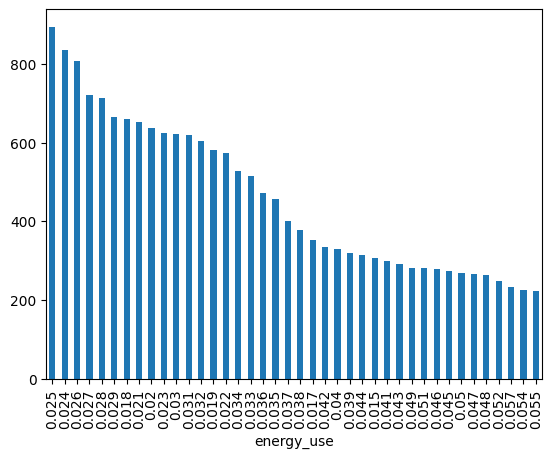

In [ ]:
# show each unique value with how many times it occurs in that column
energy_use_lf_1["energy_use"].value_counts()
# now plot that in a simple histogram but only the 100 most common values
# round the values to max 3 after the comma
energy_use_lf_1["energy_use"].round(3).value_counts().head(40).plot(kind="bar")

C:\Users\oscar\AppData\Local\Temp\ipykernel_3400\3503598125.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  energy_use_hourly = energy_use_series.resample('H').sum()


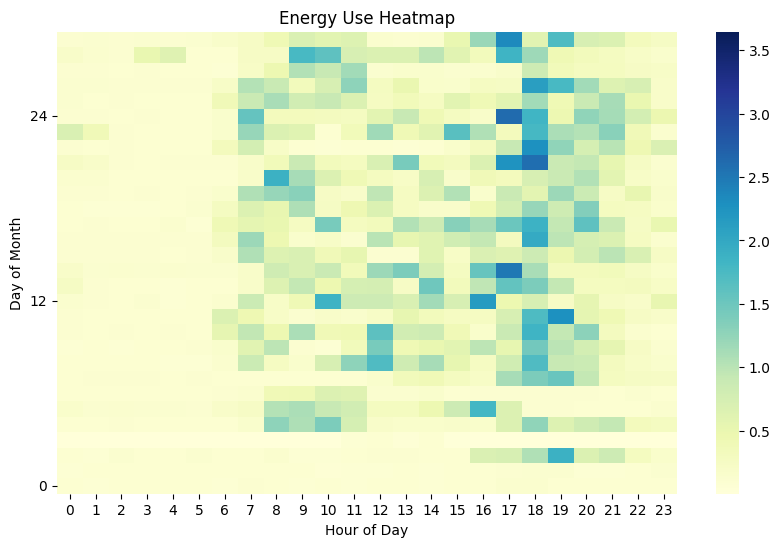

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Resample the data to hourly intervals
energy_use_hourly = energy_use_series.resample("H").sum()  # noqa: F821

# Reshape the data to a matrix with days as rows and hours as columns
energy_use_matrix = energy_use_hourly.values.reshape(-1, 24)

# Create a dataframe with the reshaped data
energy_use_df_heatmap = pd.DataFrame(energy_use_matrix, columns=range(24))

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# Create the heatmap using seaborn
sns.heatmap(energy_use_df_heatmap, cmap="YlGnBu", ax=ax)

# Set the labels and title
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Month")
ax.set_title("Energy Use Heatmap")


# Set the y-axis limits to show only 1 month
ax.set_ylim(0, 30)

# Show the heatmap
plt.show()

energy_use
2022-12-31 23:00:00       0.025
2022-12-31 23:15:00       0.017
2022-12-31 23:30:00       0.023
2022-12-31 23:45:00       0.024
2023-01-01 00:00:00       0.023
...                         ...
2023-12-31 21:45:00       0.024
2023-12-31 22:00:00       0.022
2023-12-31 22:15:00       0.046
2023-12-31 22:30:00       0.035
2023-12-31 22:45:00       0.027

[35040 rows x 1 columns]

C:\Users\oscar\AppData\Local\Temp\ipykernel_3400\784061356.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(energy_use_series, shade=True)


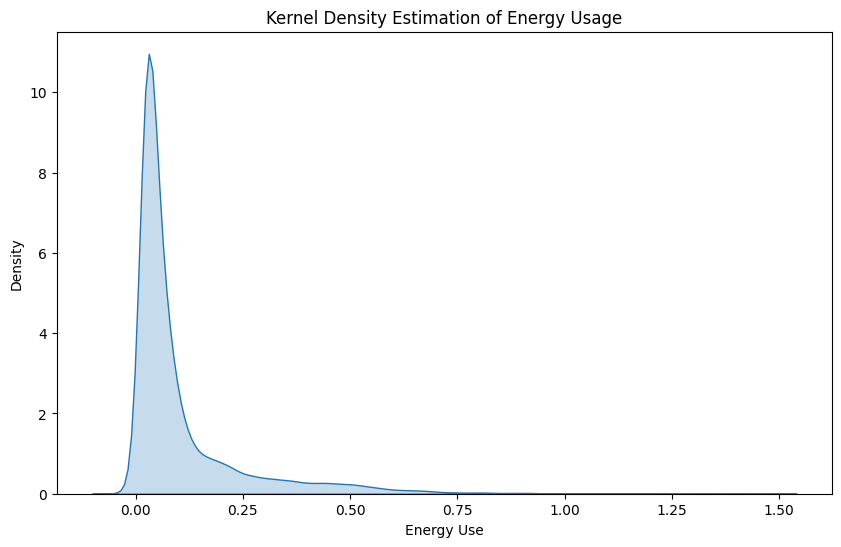

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read in pandas series from a json file
energy_use_lf_1 = pd.read_json("energy_use.json", orient="index")
energy_use_lf_1.columns = ["energy_use"]
energy_use_lf_1.Name = "energy_use"
display(energy_use_lf_1)

# Convert DataFrame to Series
energy_use_series = energy_use_lf_1.squeeze()

# Plot KDE to identify the most common usage levels
plt.figure(figsize=(10, 6))
sns.kdeplot(energy_use_series, shade=True)
plt.title("Kernel Density Estimation of Energy Usage")
plt.xlabel("Energy Use")
plt.ylabel("Density")
plt.show()

energy_use
2022-12-31 23:00:00       0.025
2022-12-31 23:15:00       0.017
2022-12-31 23:30:00       0.023
2022-12-31 23:45:00       0.024
2023-01-01 00:00:00       0.023
...                         ...
2023-12-31 21:45:00       0.024
2023-12-31 22:00:00       0.022
2023-12-31 22:15:00       0.046
2023-12-31 22:30:00       0.035
2023-12-31 22:45:00       0.027

[35040 rows x 1 columns]

C:\Users\oscar\AppData\Local\Temp\ipykernel_3400\1600994407.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(energy_use_series, shade=True)


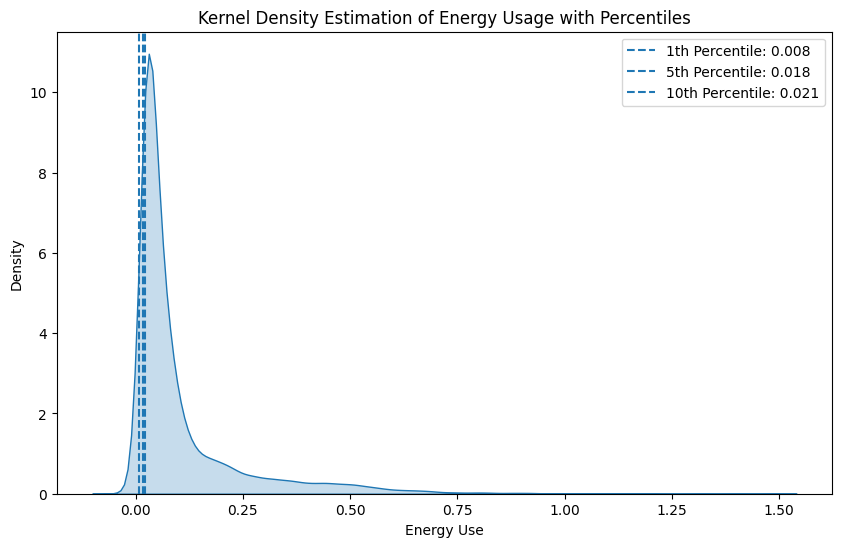

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read in pandas series from a json file
energy_use_lf_1 = pd.read_json("energy_use.json", orient="index")
energy_use_lf_1.columns = ["energy_use"]
energy_use_lf_1.Name = "energy_use"
display(energy_use_lf_1)

# Convert DataFrame to Series
energy_use_series = energy_use_lf_1.squeeze()

# Calculate percentiles
percentiles = [1, 5, 10]
percentile_values = np.percentile(energy_use_series, percentiles)

# Plot KDE to identify the most common usage levels
plt.figure(figsize=(10, 6))
sns.kdeplot(energy_use_series, shade=True)

# Plot vertical lines for percentiles
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, linestyle="--", label=f"{p}th Percentile: {value:.3f}")

plt.title("Kernel Density Estimation of Energy Usage with Percentiles")
plt.xlabel("Energy Use")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.fft import fft
from ruptures import Pelt

# from ruptures.costs import GaussianChangesCost
from statsmodels.tsa.seasonal import STL

# Load and preprocess the data

data = pd.read_json("energy_use.json", orient="index")
data.columns = ["usage"]
data.index.name = "timestamp"
data.index = pd.to_datetime(data.index)

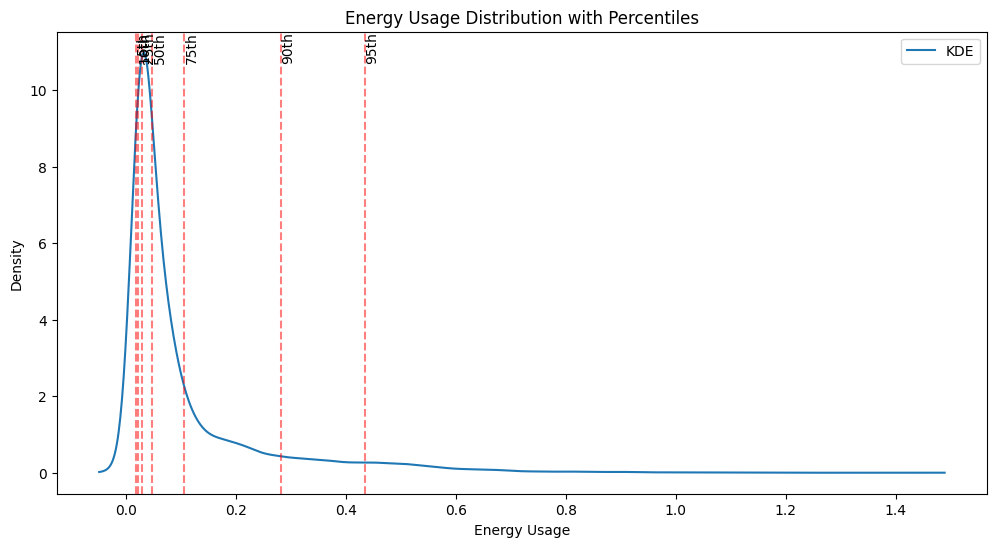

Percentile analysis:
5th percentile: 0.018
10th percentile: 0.021
25th percentile: 0.028
50th percentile: 0.048
75th percentile: 0.106
90th percentile: 0.282
95th percentile: 0.434


In [ ]:
# 1. KDE with Percentile Analysis
plt.figure(figsize=(12, 6))
kde = stats.gaussian_kde(data["usage"])
x_range = np.linspace(data["usage"].min(), data["usage"].max(), 1000)
plt.plot(x_range, kde(x_range), label="KDE")
percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(data["usage"], p)
    plt.axvline(value, color="r", linestyle="--", alpha=0.5)
    plt.text(value, plt.ylim()[1], f"{p}th", rotation=90, va="top")
plt.title("Energy Usage Distribution with Percentiles")
plt.xlabel("Energy Usage")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Percentile analysis:")
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(data['usage'], p):.3f}")

In [ ]:
# 2. PELT Change Point Detection
model = Pelt(model="rbf", jump=1).fit(data["usage"].values)
change_points = model.predict(pen=10)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["usage"])
for cp in change_points:
    plt.axvline(data.index[cp], color="r", linestyle="--", alpha=0.5)
plt.title("Energy Usage with Change Points")
plt.xlabel("Time")
plt.ylabel("Energy Usage")
plt.show()

print("\nDetected change points:")
for cp in change_points:
    print(f"Change point at: {data.index[cp]}")

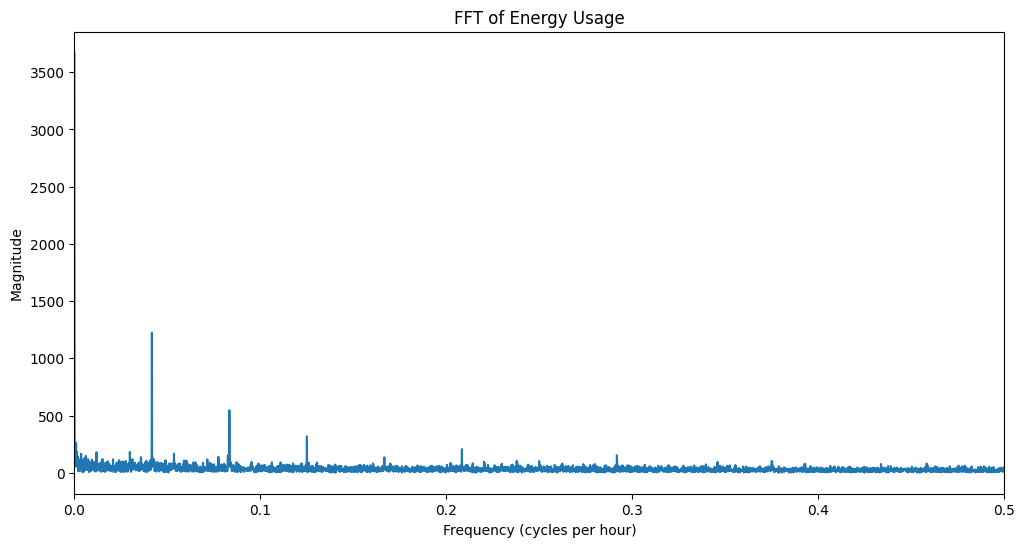


Dominant frequencies (cycles per hour):
0.0833 (period: 12.00 hours)
0.0417 (period: 24.00 hours)


In [ ]:
# 3. Fast Fourier Transform (FFT)
fft_result = fft(data["usage"].values)
frequencies = np.fft.fftfreq(len(data), d=0.25)  # 0.25 hours between samples
plt.figure(figsize=(12, 6))
plt.plot(frequencies[: len(frequencies) // 2], np.abs(fft_result)[: len(frequencies) // 2])
plt.title("FFT of Energy Usage")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Magnitude")
plt.xlim(0, 0.5)  # Focus on lower frequencies
plt.show()

print("\nDominant frequencies (cycles per hour):")
top_frequencies = frequencies[np.argsort(np.abs(fft_result))[-5:]]
for freq in top_frequencies:
    if freq > 0:
        print(f"{freq:.4f} (period: {1/freq:.2f} hours)")

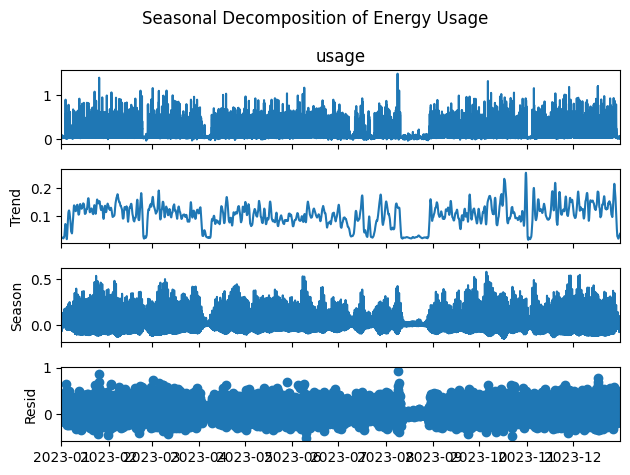

In [ ]:
# 4. Seasonal Decomposition
stl = STL(data["usage"], period=96)  # 96 quarters in a day
result = stl.fit()
fig = result.plot()
plt.suptitle("Seasonal Decomposition of Energy Usage")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Vacation Period Analysis
def analyze_vacation_period(start_date, end_date):
    vacation_data = data.loc[start_date:end_date]
    regular_data = data.drop(vacation_data.index)

    print(f"\nVacation Period Analysis ({start_date} to {end_date}):")
    print(f"Average usage during vacation: {vacation_data['usage'].mean():.3f}")
    print(f"Average usage during regular periods: {regular_data['usage'].mean():.3f}")
    print("Standby usage estimate (5th percentile):")
    print(f"  During vacation: {np.percentile(vacation_data['usage'], 5):.3f}")
    print(f"  During regular periods: {np.percentile(regular_data['usage'], 5):.3f}")


# Example usage:
analyze_vacation_period("2023-08-11", "2023-08-28")


Vacation Period Analysis (2023-08-11 to 2023-08-28):
Average usage during vacation: 0.025
Average usage during regular periods: 0.109
Standby usage estimate (5th percentile):
  During vacation: 0.011
  During regular periods: 0.018
